This Notebook will go over Feature extraction , some Visualization and Modeling
lets start with imports and loading the main class Molecules that works on a directory with feather files,
we will use the example in the package.
Change ROOT_DIR accordingly.


In [ ]:
%reset -f
%reload_ext autoreload
%autoreload 2

import os
import sys
import importlib
import numpy as np
import pandas as pd

# === Setup ===
ROOT_DIR = r'C:\Users\edens\Documents\GitHub\LabCode\MolFeatures'
sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'M3_modeler'))
sys.path.append(os.path.join(ROOT_DIR, 'M2_data_extractor'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))

os.chdir(ROOT_DIR)  # Set working directory

# === Clear old module caches ===
for module in ['data_extractor', 'feather_extractor', 'gaussian_handler', 'help_functions', 'modeling', 'plot']:
    sys.modules.pop(module, None)

# === Safe Imports ===
try:
    from data_extractor import Molecules, extract_connectivity
    from feather_extractor import logs_to_feather
    import gaussian_handler
    from gaussian_handler import feather_file_handler
    from help_functions import dict_to_horizontal_df, get_df_from_file
    import help_functions
    import visualize
    from modeling import (
        ClassificationModel,
        LinearRegressionModel,
        fit_and_evaluate_single_combination_regression,
        fit_and_evaluate_single_combination_classification
    )
    import plot
except ModuleNotFoundError as e:
    print(f"Module import failed: {e}")

# === Config ===
pd.set_option('display.max_columns', None)

# === Load molecular data ===
feather_path = r'C:\Users\edens\Documents\GitHub\possible_dataset_info\Lutz\Reunmbered_Feather_Files'
mols = Molecules(feather_path)


Molecules Loaded: ['FL_lig_4_str_optimized.feather', 'FL_lig_5_str_optimized.feather', 'FL_lig_6_str_optimized.feather', 'FL_lig_7_str_optimized.feather'] Failed Molecules: []


Great we can see the files Loaded ! 
lets print the methods for the mols object we created to see what wee can use.

In [2]:
methods=[method for method in dir(mols) if not method.startswith('_')]
print(methods)

['export_all_xyz', 'extract_all_dfs', 'extract_all_xyz', 'failed_molecules', 'filter_molecules', 'get_bend_vibration_dict', 'get_bond_angle_dict', 'get_bond_length_dict', 'get_charge_df_dict', 'get_charge_diff_df_dict', 'get_dipole_dict', 'get_molecules_comp_set_app', 'get_npa_dict', 'get_ring_vibration_dict', 'get_sterimol_dict', 'get_stretch_vibration_dict', 'molecules', 'molecules_names', 'molecules_path', 'old_molecules', 'old_molecules_names', 'success_molecules', 'visualize_molecules', 'visualize_smallest_molecule', 'visualize_smallest_molecule_morfeus']


In [ ]:
mols.get_dipole_dict([])

Great now lets use visualize_molecules to see the first molecule of the set.


In [ ]:
mols.visualize_molecules([0])

🔥 sterimol_trace failed: TypeError("'NoneType' object is not subscriptable")


Now that we see the molecules and atom numbering we can extract features. Remember it need to be numbered the same across the set !

In [2]:
answers_dict ={
    "Ring Vibration atoms - by order -> Pick primary atom and para to it: \n example: 13,17": [8],
    "Stretch Threshold": [1400],
    "Stretching Vibration atoms- enter bonded atom pairs: \n example: 1,2 4,5": [1,3],
    "Bend Threshold": [1600],
    "Bending Vibration atoms - enter atom pairs that have a common atom: \n example: 4,7":[5,6],
    "Center_Atoms Dipole": [],
    "Dipole atoms - indices for coordination transformation: \n example: 4,5,6 - origin, y-axis, new xy plane": [[2,3,1], [29,27,28], [8,7,9]],
    "Sub-Atoms NPA": [],
    "NPA manipulation atoms - Insert atoms to show NPA: \n example: 1,2,4": [[2,3,1], [29,27,28], [8,7,9]],
    "charges values - Insert atoms to show charge: \n example: 1,2,3,4": [1,2,3,28],
    "charge_diff - Insert atoms to show charge difference: \n example: 1,2 3,4": [[2,3], [1,2]],
    "Sterimol atoms - Primary axis along: \n example: 7,8": [[4,1],[1,4],[17,14]],
    "Bond_length - Atom pairs to calculate difference: \n example: 1,2 4,5": [[1,2], [1,3]],
    "Bond_Angle - Insert a list of atom triads/quartets for which you wish to have angles/dihedrals: \n example: 1,3,4 5,6,7,4": [2,1,4,7]
}

df=mols.get_molecules_comp_set_app(entry_widgets=answers_dict,answers_list=None)

[DEBUG] Called get_ring_vibrations on molecule: basic
[DEBUG] ring_atom_indices argument: [8]
[DEBUG] Detected single atom set input (one ring or atom set)
[DEBUG] Benzene ring indices grouped: [[12, 8], [10, 7], [14, 9]]
[DEBUG] Filtered DataFrame:
   index  Product  Frequency  Sin_angle
0     64  -0.5753  1657.1445   0.483498
1     65  -0.5942  1680.2718   0.872609
[DEBUG] Result DataFrame:
                       0
cross        1657.144500
cross_angle    28.914133
para         1680.271800
para_angle     60.763308
[DEBUG] Called get_ring_vibrations on molecule: m_Br
[DEBUG] ring_atom_indices argument: [8]
[DEBUG] Detected single atom set input (one ring or atom set)
[DEBUG] Benzene ring indices grouped: [[12, 8], [10, 7], [14, 9]]
[DEBUG] Filtered DataFrame:
   index  Product  Frequency  Sin_angle
0     65  -0.6293  1641.5631   0.553350
1     66  -0.6230  1669.3498   0.814842
[DEBUG] Result DataFrame:
                       0
cross        1641.563100
cross_angle    33.597172
para     

Traceback (most recent call last):
  File "C:\Users\edens\Documents\GitHub\LabCode\MolFeatures\M2_data_extractor\data_extractor.py", line 732, in get_ring_vibrations
    z, x, c, v, b, n = get_benzene_ring_indices(self.bonds_df, ring_atom_indices)
TypeError: cannot unpack non-iterable NoneType object


In [1]:
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import pandas as pd

def plot_shap_summary(model, X, feature_names=None, max_display=20, figsize=(12, 8)):
    """
    Plot SHAP summary visualization for the given model.
    
    Parameters:
    -----------
    model : model object
        The fitted model for which to calculate SHAP values.
        Should have a predict method.
    X : numpy.ndarray or pandas.DataFrame
        Feature matrix for which to compute SHAP values.
    feature_names : list, optional
        Names of features. If None and X is a DataFrame, column names are used.
    max_display : int, optional
        Maximum number of features to show in the plot.
    figsize : tuple, optional
        Figure size (width, height) in inches.
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object.
    """

    # Determine feature names
    if feature_names is None and isinstance(X, pd.DataFrame):
        feature_names = X.columns.tolist()
    
    # Create SHAP explainer based on the model type
    explainer = None
    try:
        # Try to use the most appropriate explainer
        if hasattr(model, "predict_proba"):
            explainer = shap.Explainer(model)
        else:
            explainer = shap.Explainer(model)
    except Exception as e:
        print(f"Error creating explainer: {e}")
        # Fallback to KernelExplainer which works with any model
        explainer = shap.KernelExplainer(model.predict, shap.sample(X, 50))
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X)
    
    # Handle different output formats from different explainers
    if isinstance(shap_values, list):
        # For multi-class models, use the first class
        shap_values = shap_values[0]
    
    # Create plot
    plt.figure(figsize=figsize)
    fig = plt.gcf()
    
    # Plot SHAP summary
    if feature_names:
        shap.summary_plot(shap_values, X, feature_names=feature_names, 
                            max_display=max_display, show=False)
    else:
        shap.summary_plot(shap_values, X, max_display=max_display, show=False)
    
    plt.tight_layout()
    plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def plot_shap_dependence(model, X, feature_idx, interaction_idx=None, feature_names=None, figsize=(10, 6)):
    """
    Plot SHAP dependence plot for a specific feature, optionally with interaction.
    
    Parameters:
    -----------
    model : model object
        The fitted model for which to calculate SHAP values.
    X : numpy.ndarray or pandas.DataFrame
        Feature matrix for which to compute SHAP values.
    feature_idx : int or str
        Index or name of the feature to plot.
    interaction_idx : int or str, optional
        Index or name of the feature to use for interaction coloring.
    feature_names : list, optional
        Names of features. If None and X is a DataFrame, column names are used.
    figsize : tuple, optional
        Figure size (width, height) in inches.
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object.
    """
    # Determine feature names
    if feature_names is None and isinstance(X, pd.DataFrame):
        feature_names = X.columns.tolist()
        
        # If feature_idx or interaction_idx is a string, convert to index
        if isinstance(feature_idx, str):
            feature_idx = feature_names.index(feature_idx)
        if interaction_idx is not None and isinstance(interaction_idx, str):
            interaction_idx = feature_names.index(interaction_idx)
    
    # Create SHAP explainer
    try:
        explainer = shap.Explainer(model)
    except Exception as e:
        print(f"Error creating explainer: {e}")
        explainer = shap.KernelExplainer(model.predict, shap.sample(X, 50))
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X)
    
    # Handle different output formats
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    
    # Create plot
    plt.figure(figsize=figsize)
    fig = plt.gcf()
    
    # Plot SHAP dependence
    if feature_names:
        # Get actual feature name
        feature_name = feature_names[feature_idx] if isinstance(feature_idx, int) else feature_idx
        interaction_name = None
        if interaction_idx is not None:
            interaction_name = feature_names[interaction_idx] if isinstance(interaction_idx, int) else interaction_idx
        
        shap.dependence_plot(
            feature_idx, shap_values, X, 
            interaction_index=interaction_idx,
            feature_names=feature_names, 
            show=False
        )
        
        # Update title to be more descriptive
        plt.title(f"SHAP Dependence Plot for {feature_name}" + 
                    (f" with {interaction_name} Interaction" if interaction_name else ""))
    else:
        shap.dependence_plot(
            feature_idx, shap_values, X, 
            interaction_index=interaction_idx,
            show=False
        )
    
    plt.tight_layout()
    save_name = f"shap_dependence_{feature_idx}"
    if interaction_idx is not None:
        save_name += f"_interaction_{interaction_idx}"
    plt.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def analyze_shap_values(model, X, feature_names=None, target_name="output", n_top_features=10):
    """
    Perform comprehensive SHAP analysis on a model and return detailed results.
    
    Parameters:
    -----------
    model : model object
        The fitted model to analyze.
    X : numpy.ndarray or pandas.DataFrame
        Feature matrix for which to compute SHAP values.
    feature_names : list, optional
        Names of features. If None and X is a DataFrame, column names are used.
    target_name : str, optional
        Name of the target variable for reporting.
    n_top_features : int, optional
        Number of top features to include in the detailed analysis.
    
    Returns:
    --------
    dict
        Dictionary containing SHAP analysis results, including:
        - shap_values: Raw SHAP values
        - feature_importance: DataFrame of features sorted by mean absolute SHAP value
        - interaction_strength: DataFrame of feature interactions (if supported)
    """
    
    
    # Determine feature names
    if feature_names is None:
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns.tolist()
        else:
            feature_names = [f"Feature {i}" for i in range(X.shape[1])]
    
    results = {}
    
    # Create explainer
    try:
        explainer = shap.Explainer(model)
        print("Using TreeExplainer for SHAP analysis")
    except Exception as e:
        print(f"TreeExplainer failed: {e}. Falling back to KernelExplainer.")
        explainer = shap.KernelExplainer(model.predict, shap.sample(X, min(50, X.shape[0])))
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X)
    
    # Handle different output formats
    if isinstance(shap_values, list):
        # For multi-class models, use mean across classes or first class
        if len(shap_values) > 1:
            print(f"Multi-class model detected with {len(shap_values)} classes")
            mean_shap = np.abs(np.array(shap_values)).mean(axis=0)
            results['shap_values'] = shap_values
            results['mean_shap'] = mean_shap
        else:
            mean_shap = np.abs(shap_values[0])
            results['shap_values'] = shap_values[0]
            results['mean_shap'] = mean_shap
    else:
        mean_shap = np.abs(shap_values)
        results['shap_values'] = shap_values
        results['mean_shap'] = mean_shap
    
    # Feature importance based on SHAP values
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Mean Absolute SHAP Value': np.mean(np.abs(mean_shap), axis=0),
        'Max Absolute SHAP Value': np.max(np.abs(mean_shap), axis=0)
    })
    feature_importance = feature_importance.sort_values('Mean Absolute SHAP Value', ascending=False)
    results['feature_importance'] = feature_importance
    
    # Get top features
    top_features = feature_importance['Feature'].head(n_top_features).tolist()
    results['top_features'] = top_features
    
    # Plot SHAP summary
    fig_summary = plot_shap_summary(model, X, feature_names, max_display=n_top_features)
    results['fig_summary'] = fig_summary
    
    # Plot dependence plots for top features
    dependence_plots = []
    for feature in top_features[:5]:  # Limit to first 5 to avoid too many plots
        fig_dep = plot_shap_dependence(model, X, 
                                        feature if isinstance(X, pd.DataFrame) else feature_names.index(feature),
                                        feature_names=feature_names)
        dependence_plots.append(fig_dep)
    results['dependence_plots'] = dependence_plots
    
    # Try to calculate and plot interactions (if supported)
    try:
        if hasattr(explainer, 'shap_interaction_values'):
            shap_interaction = explainer.shap_interaction_values(X)
            if isinstance(shap_interaction, list):
                shap_interaction = shap_interaction[0]
            
            # Calculate interaction strengths
            interaction_strength = np.zeros((X.shape[1], X.shape[1]))
            for i in range(X.shape[1]):
                for j in range(X.shape[1]):
                    if i != j:
                        interaction_strength[i, j] = np.abs(shap_interaction[:, i, j]).mean()
            
            interaction_df = pd.DataFrame(interaction_strength, 
                                            index=feature_names,
                                            columns=feature_names)
            results['interaction_strength'] = interaction_df
            
            # Plot top interactions
            plt.figure(figsize=(10, 8))
            sns.heatmap(interaction_df, cmap='viridis', annot=True, fmt=".4f")
            plt.title("SHAP Interaction Strengths")
            plt.tight_layout()
            plt.savefig('shap_interactions.png', dpi=300, bbox_inches='tight')
            results['fig_interaction'] = plt.gcf()
    except Exception as e:
        print(f"Interaction analysis not supported by this explainer: {e}")
    
    return results

ModuleNotFoundError: No module named 'shap'

Database already exists at: results_Lutz_new_features.db
Table 'regression_results' has been ensured to exist.
linear model selected

--- Correlation Report ---
Features with correlation above 0.8:
['cm5_diff_1-5', 'loc_B5_2-17', 'dip_x_NPA_1-2-3', 'cm5_atom_4', 'total_dipole_1-2-3', 'cm5_diff_15-5', 'nbo_atom_21', 'dipole_z_1-2-3', 'B5_17-2', 'B5_7-6', 's_C2_L_FL', 'dip_z_NPA_1-2-3', 'bond_length_1-2', 'cm5_atom_3', 'B1_6-7', 'L_7-6', 'Frequency_Stretch_1_21', 'dip_z_NPA_4-5-6', 'total_dipole_2-3-4', 'nbo_atom_2', 'cm5_atom_2', 'IE (Ha)', 'hirshfeld_atom_3', 'dipole_y_2-3-4', 'nbo_atom_6', 'hirshfeld_atom_1', 'L_17-2', 'dipole_x_1-2-3', 'L_2-17', 'loc_B5_6-7', 'dipole_y_1-2-3', 'dipole_z_2-3-4', 'cm5_atom_6', 'dihedral_[5, 4, 3, 2]', 'cm5_atom_21', 'hirshfeld_diff_15-5', 'nbo_C2_CMC', 'total_dipole_NPA_1-2-3', 'dip_y_NPA_1-2-3', 'hirshfeld_diff_1-5', 'hirshfeld_atom_5', 'B1_B5_angle_7-6', 'cm5_atom_17', 'dipole_x_2-3-4', 'nbo_atom_5', 'nbo_diff_1-5', 'nbo_atom_4', 'L_6-7', 'nbo_atom_1

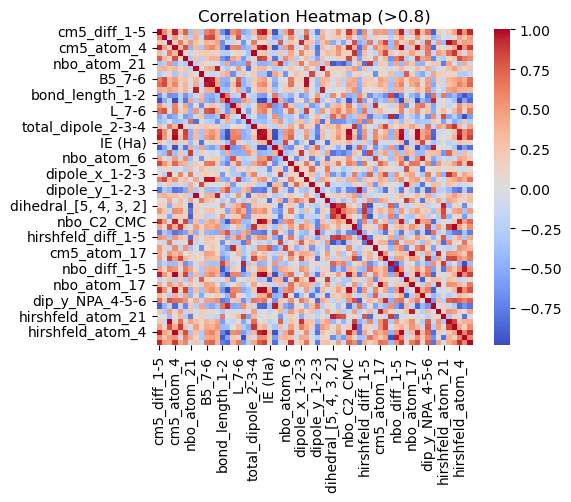


Correlated features were not dropped.



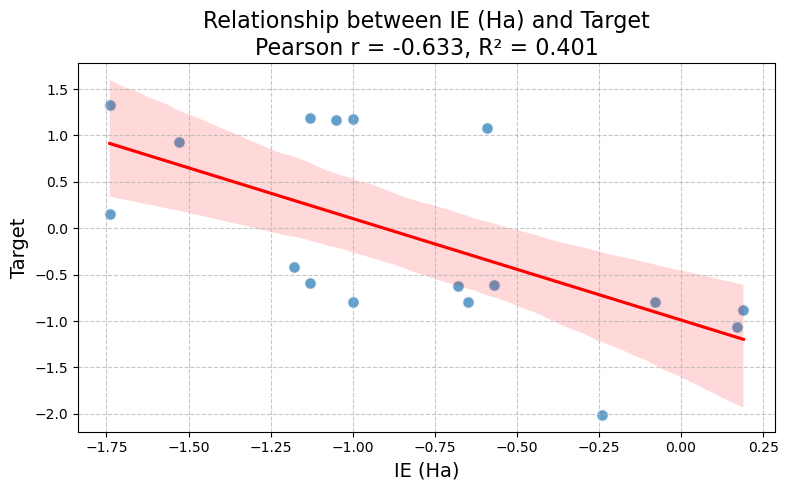

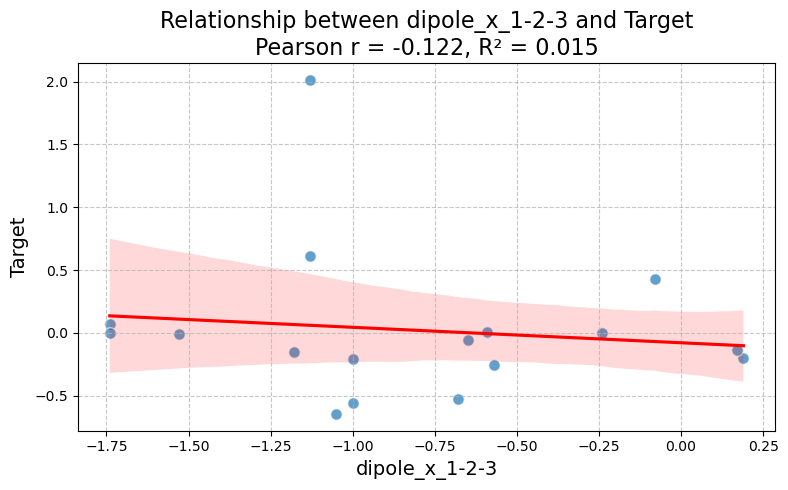

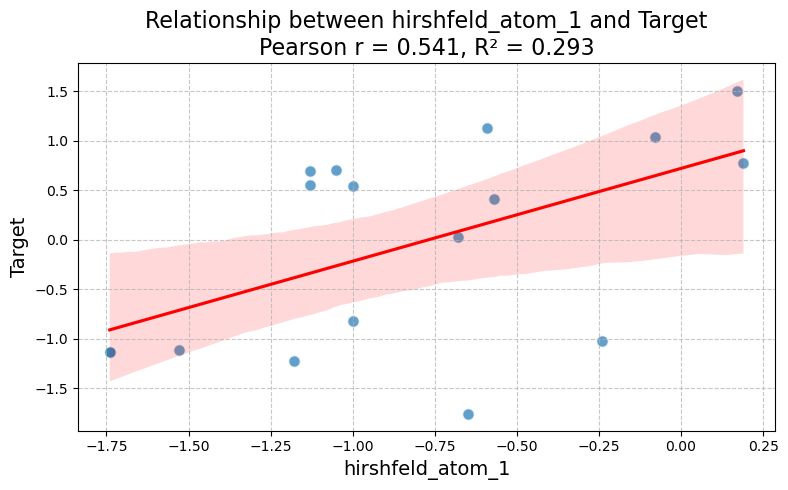

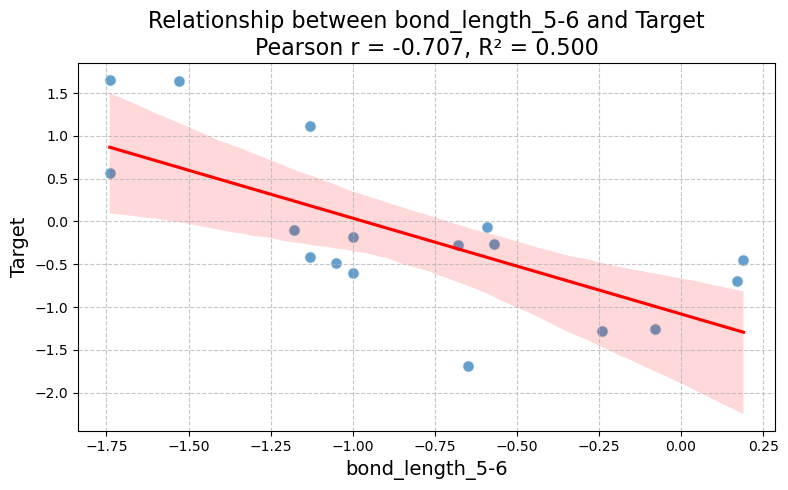

[<Figure size 800x500 with 1 Axes>,
 <Figure size 800x500 with 1 Axes>,
 <Figure size 800x500 with 1 Axes>,
 <Figure size 800x500 with 1 Axes>]

In [ ]:
csv_path=r'C:\Users\edens\Documents\GitHub\Robert\Lutz_new_features.csv'

# csv_path=r'C:\Users\edens\Documents\GitHub\lucas_project\new_update_logs\added_features_try34.csv'

csv_filepaths = {
'features_csv_filepath': csv_path,
'target_csv_filepath': ''
}
# ['LS2008','LS1643']
# ('B1_B5_angle_4-3', 'L_11-6', 'bond_length_11-12')
df=pd.read_csv(csv_path, index_col=0)

# df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
leave_out = [
    "LS1621", "LS1622", "LS1630", "LS1641", "LS1642", "LS1643",
    "LS1661", "LS1663", "LS1714", "LS1715", "LS1716", "LS1717",
    "LS1721", "LS1723", "LS1726", "LS1734", "LS1736",
    "LS2000", "LS2001", "LS2002", "LS2003", "LS2006", "LS2007", "LS2008"
]

# pick 4 random samples to leave out
# leave_out = (np.random.choice(df_drop.index-1, size=5, replace=False)-1).tolist()
# print(f"idx: {df.index}")
leave_out=[3,22,16,15,12] # 
leave_out=[1,20,14,13,10] # 
Regression_model = LinearRegressionModel(csv_filepaths, process_method='one csv', output_name='output', leave_out=leave_out, min_features_num=2, max_features_num=None, metrics=None, return_coefficients=False)

features=['IE (Ha)', 'dipole_x_1-2-3','hirshfeld_atom_1','bond_length_5-6']
features_2=['IE (Ha)', 'dip_x_NPA_4-5-6','hirshfeld_atom_1','bond_length_5-6']
features_origin =['IE (Ha)','nbo_C2_CMC','nbo_C6_CMC','s_C2_L_FL']
df_features = Regression_model.features_df[features]
# analyze_shap_values(Regression_model.model, df_features, feature_names=features)
# plot.plot_all_features_vs_target(df_features, Regression_model.target_vector)


# plot.generate_and_display_q2_scatter_plot(Regression_model,features_origin)


# plot.generate_and_display_q2_scatter_plot(Regression_model,features)


# plot.generate_and_display_q2_scatter_plot(Regression_model,features_2)


[autoreload of plot failed: Traceback (most recent call last):
  File "c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "c:\Users\edens\anaconda3\envs\labenv\lib\importlib\__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'plot'
]


Starting generate_and_display_q2_scatter_plot...
Extracting features from model.features_df...
Using single train/test split with test size 0.1 and random state 42
Index 0: Actual = -1.000, Predicted = -0.857, % Error = -14.35%
Index 1: Actual = 0.190, Predicted = -0.135, % Error = -171.27%
Index 2: Actual = -0.570, Predicted = -0.356, % Error = -37.54%
Index 3: Actual = -0.680, Predicted = -0.440, % Error = -35.31%
Index 4: Actual = -1.130, Predicted = -0.945, % Error = -16.41%
Index 5: Actual = -0.650, Predicted = -0.727, % Error = 11.90%
Index 6: Actual = -0.240, Predicted = -0.502, % Error = 109.34%
Index 7: Actual = -1.740, Predicted = -1.951, % Error = 12.10%
Index 8: Actual = -1.180, Predicted = -1.031, % Error = -12.63%
Index 9: Actual = -1.530, Predicted = -1.711, % Error = 11.80%
Index 10: Actual = -1.740, Predicted = -1.545, % Error = -11.18%
Index 11: Actual = -0.590, Predicted = -0.887, % Error = 50.35%
Index 12: Actual = -1.050, Predicted = -0.932, % Error = -11.21%
Index

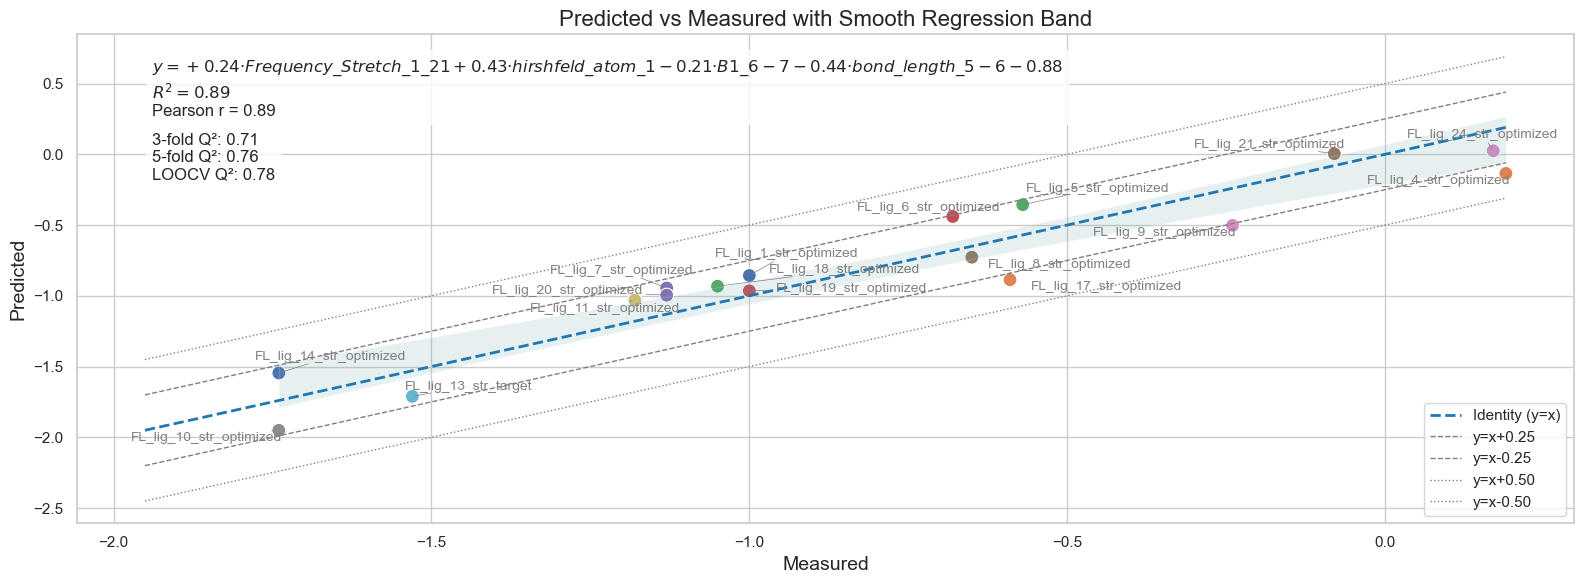

In [3]:
features_sterimol =['Frequency_Stretch_1_21','hirshfeld_atom_1','B1_6-7','bond_length_5-6']

plot.generate_and_display_q2_scatter_plot(Regression_model,features_sterimol)

In [1]:
sterimol_example = mols.molecules[0].get_sterimol([4,1])

NameError: name 'mols' is not defined